In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KernelDensity

In [2]:
%matplotlib inline

## Helper functions

In [4]:
def l2_distance(a, b):
    """Compute L2 distance between a and b
    a, b - iterables of dimension 2
    """
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

## Load and visualize the data points

In [85]:
data_points = pd.read_csv("spiral1.txt")

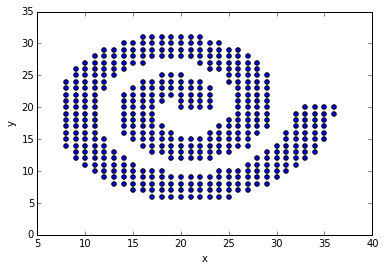

In [86]:
data_points.plot(kind='scatter', x='x', y='y')

## Compute parameters of normal distributions centered at each of the data points

In [57]:
def k_nearest_neighbors(k, idx, data_points):
    """Return k nearest points from data_points including the point itself"""
    
    point = data_points.iloc[idx]
    
    # Make sure k is not larger than the amount of elements in dataframe
    k = min(k, data_points.shape[0])

    def dist_to_point(other_pt):
        return (point.x - other_pt.x)**2 + (point.y - other_pt.y)**2
    
    data_points['distance sq'] = data_points.apply(dist_to_point, axis=1)
    closest_points = data_points.sort_values(by='distance sq').head(k).reset_index(drop=True)
    
    return closest_points

In [70]:
def compute_distribution_params(closest_points):
    # Unpack the point
    mu_x = closest_points['x'].mean()
    mu_y = closest_points['y'].mean()
    k = len(closest_points.index)
    
    # Subtract mean from all the neighboring points
    centered = pd.DataFrame()
    centered['x'] = (closest_points['x'] - mu_x)
    centered['y'] = (closest_points['y'] - mu_y)
    
    # Variance
    var_x = (centered['x']**2).sum() / k
    var_y = (centered['y']**2).sum() / k
    
    # Standard deviation
    sigma_x = np.sqrt(var_x)
    sigma_y = np.sqrt(var_y)

    # Pearson's correlation coefficient
    ro = (centered['x'] * centered['y']).sum() / (k * sigma_x * sigma_y)
    
    return [mu_x, mu_y, sigma_x, sigma_y, ro]

In [87]:
k = 5 # Number of nearest neigbors to consider

distributions = pd.DataFrame(columns = ['mu_x', 'mu_y', 'sigma_x', 'sigma_y', 'ro'])

for idx, row in data_points.iterrows():
    closest_points = k_nearest_neighbors(k, idx, data_points)
    distributions.loc[idx] = compute_distribution_params(closest_points)

## Discretize the domain

In [89]:
resolution = 20
min_x, min_y = data_points[['x', 'y']].min()
max_x, max_y = data_points[['x', 'y']].max()

Domain is a **resolultion** x **resolution** size grid with range [**min_x**, **max_x**] x [**min_y**, **max_y**]

In [90]:
x = np.linspace(min_x * 0.9, max_x * 1.1, resolution)
y = np.linspace(min_y * 0.9, max_y * 1.1, resolution)

In [91]:
b = np.zeros([resolution, resolution])

## Classic kernel density estimation

In [96]:
def density_of_normal(d, h):
    result = 1 / ((2 * np.pi) ** 0.5 * h) * np.exp(- d ** 2 / (2 * h ** 2))
    return result

In [97]:
def estimate_density(i, j, points, h):
    val = 0
    n = len(points.index)
    for index, pt in points.iterrows():
        dist = l2_distance((x[j], y[i]), (pt))
        val += 1 / (n * h) * density_of_normal(dist, h)
    return val

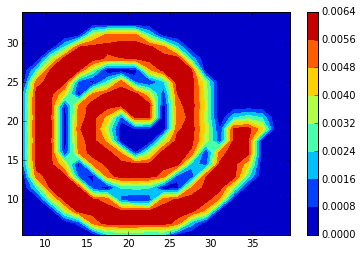

In [109]:
for i in range(resolution):
    for j in range(resolution):
        b[i, j] = estimate_density(i, j, data_points, 0.5)
H = plt.contourf(x,y,b)
plt.colorbar()

## Kernel density estimation with non-isotropic Gaussians

In [92]:
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, ro=0):
    return (1/(2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - ro**2))) * np.exp(
    -1 / 2 * (1 - ro**2) * ((x - mu_x)**2 / sigma_x**2 + (y - mu_y)**2 / sigma_y**2 -
                           2 * ro * (x - mu_x) * (y - mu_y) / (sigma_x * sigma_y)))

In [94]:
def estimate_density_nonisotropic(i, j, data_points):
    val = 0
    n = len(data_points.index)
    for index, pt in distributions.iterrows():
        val += gaussian_2d(i, j, pt.mu_x, pt.mu_y, pt.sigma_x, pt.sigma_y, pt.ro)
    return val

In [87]:
k = 5 # Number of nearest neigbors to consider

distributions = pd.DataFrame(columns = ['mu_x', 'mu_y', 'sigma_x', 'sigma_y', 'ro'])

for idx, row in data_points.iterrows():
    closest_points = k_nearest_neighbors(k, idx, data_points)
    distributions.loc[idx] = compute_distribution_params(closest_points)

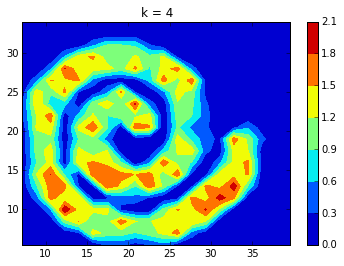

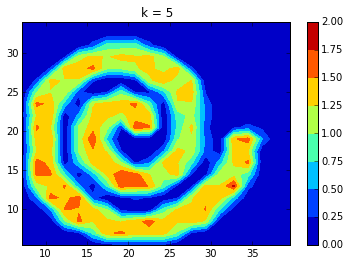

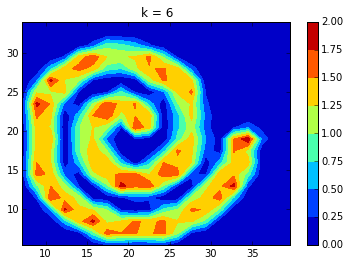

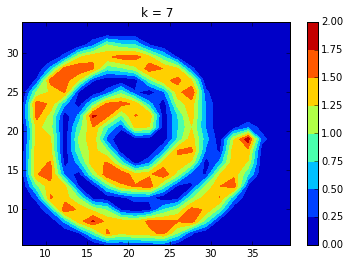

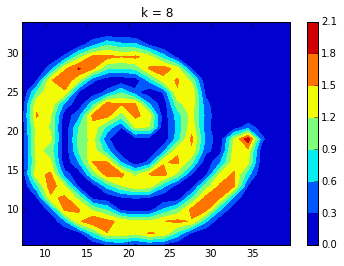

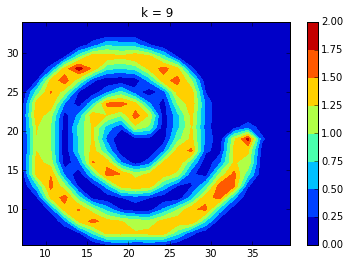

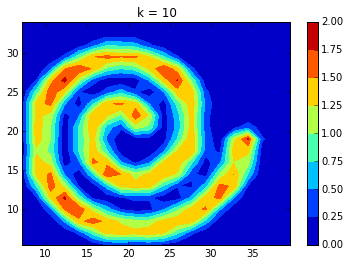

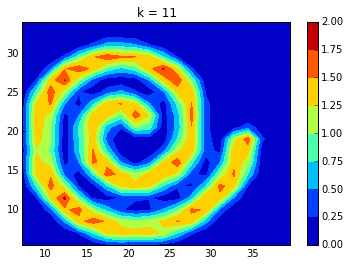

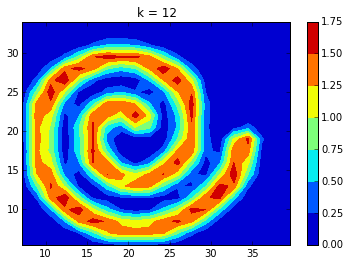

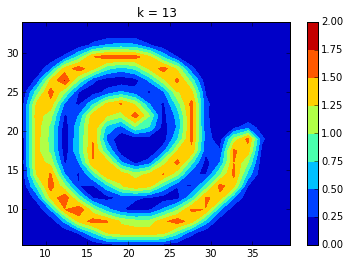

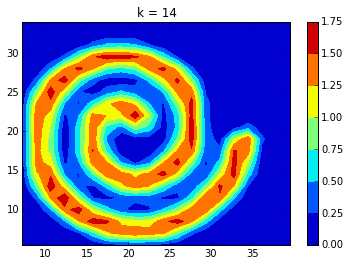

In [107]:
for k in range(4, 15):
    distributions = pd.DataFrame(columns = ['mu_x', 'mu_y', 'sigma_x', 'sigma_y', 'ro'])
    for idx, row in data_points.iterrows():
        closest_points = k_nearest_neighbors(k, idx, data_points)
        distributions.loc[idx] = compute_distribution_params(closest_points)
    
    for i in range(resolution):
        for j in range(resolution):
            b[i, j] = estimate_density_nonisotropic(x[j], y[i], data_points)
    H = plt.contourf(x,y,b)
    plt.colorbar()
    plt.title("k = " + str(k))
    plt.show()